In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
# Dataset train dan dataset validasi
train_ds, validation_ds = ds["train"], ds["validation"]

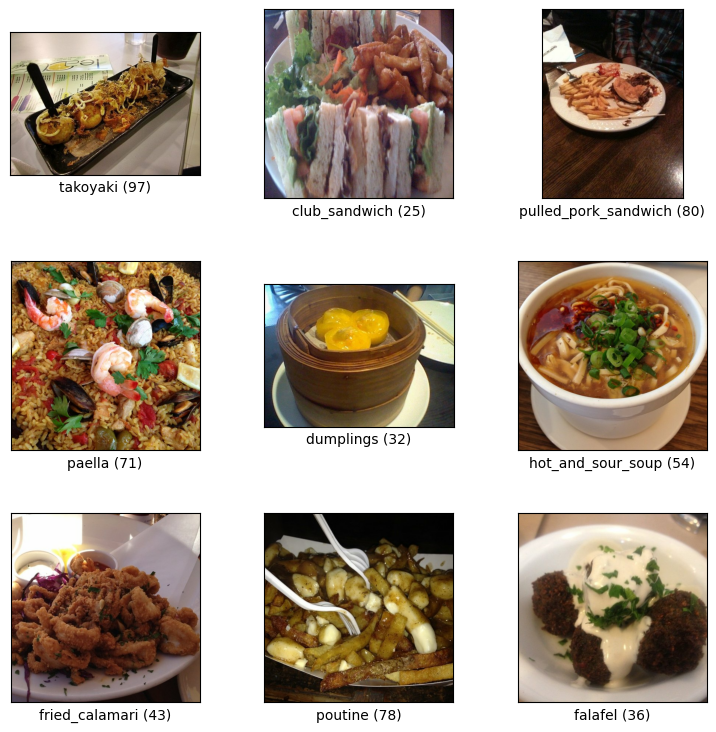

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
# Ambil label dari info
label_names = ds_info.features['label'].names

# Tampilkan label
print("Daftar label:", label_names)

Daftar label: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaro

In [7]:
# Ambil label dari info
label_names = ds_info.features['label'].names

# Tampilkan label dengan nomor
for index, label in enumerate(label_names):
    print(f"{index}: {label}")

0: apple_pie
1: baby_back_ribs
2: baklava
3: beef_carpaccio
4: beef_tartare
5: beet_salad
6: beignets
7: bibimbap
8: bread_pudding
9: breakfast_burrito
10: bruschetta
11: caesar_salad
12: cannoli
13: caprese_salad
14: carrot_cake
15: ceviche
16: cheesecake
17: cheese_plate
18: chicken_curry
19: chicken_quesadilla
20: chicken_wings
21: chocolate_cake
22: chocolate_mousse
23: churros
24: clam_chowder
25: club_sandwich
26: crab_cakes
27: creme_brulee
28: croque_madame
29: cup_cakes
30: deviled_eggs
31: donuts
32: dumplings
33: edamame
34: eggs_benedict
35: escargots
36: falafel
37: filet_mignon
38: fish_and_chips
39: foie_gras
40: french_fries
41: french_onion_soup
42: french_toast
43: fried_calamari
44: fried_rice
45: frozen_yogurt
46: garlic_bread
47: gnocchi
48: greek_salad
49: grilled_cheese_sandwich
50: grilled_salmon
51: guacamole
52: gyoza
53: hamburger
54: hot_and_sour_soup
55: hot_dog
56: huevos_rancheros
57: hummus
58: ice_cream
59: lasagna
60: lobster_bisque
61: lobster_roll_sa

In [8]:
'''
Dataset train_ds yang diproses ulang menggunakan map yang berisi gambar diubah ukuran menjadi 128x128 piksel,
dan label yang semula berupa nama diubah menjadi nilai biner (True atau False),
tergantung apakah gambar tersebut merupakan gambar "hot dog" atau bukan.
'''
MAX_SIDE_LENGTH = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LENGTH, MAX_SIDE_LENGTH]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

validation_ds = validation_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LENGTH, MAX_SIDE_LENGTH]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

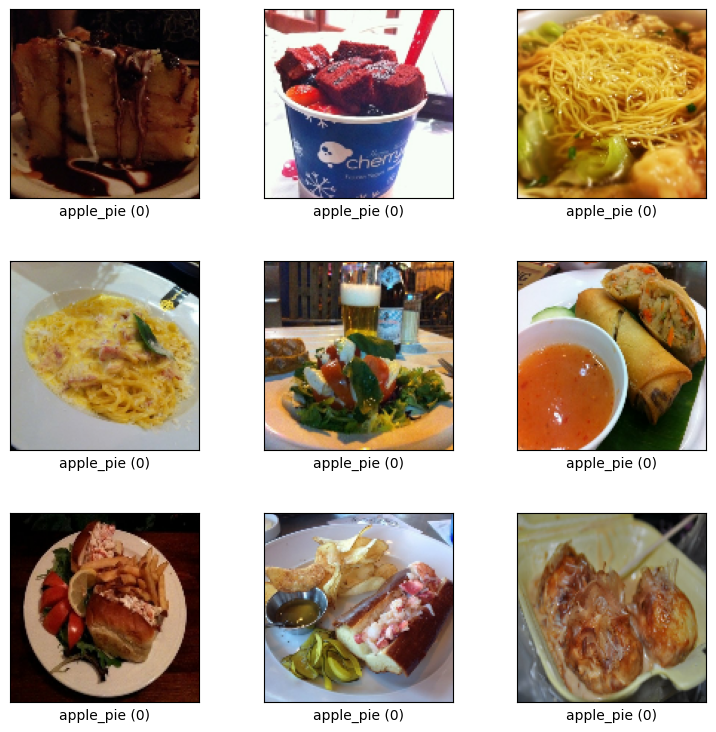

In [9]:
fig = tfds.show_examples(train_ds, ds_info)

In [10]:
# Untuk menangani ketidakseimbangan kelas (class imbalance).

# Menentukan ukuran dataset hot dog untuk pelatihan dan validasi
train_hd_size, valid_hd_size = 750, 250

# Membuat dataset baru yang hanya berisi gambar-gambar "hot dog"
# - filter(lambda image, label: label == 1) menyaring dataset untuk hanya menyertakan gambar dengan label 1 (hot dog)
# - repeat(3) menggandakan dataset yang berisi hot dog sebanyak 3 kali untuk memperbesar jumlah data hot dog
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)

# Membuat dataset baru yang hanya berisi gambar-gambar yang bukan "hot dog"
# - filter(lambda image, label: label == 0) menyaring dataset untuk hanya menyertakan gambar dengan label 0 (bukan hot dog)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)


In [11]:
valid_hotdogs = validation_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = validation_ds.filter(lambda image, label: label == 0)

In [12]:
# Membuat dataset pelatihan baru dengan cara mengambil sampel dari dua dataset: train_hotdogs dan train_nothotdogs
# tf.data.Dataset.sample_from_datasets() digunakan untuk menggabungkan dua dataset dengan pengambilan sampel acak
# [train_hotdogs, train_nothotdogs] adalah daftar dataset yang ingin kita gabungkan
# [0.5, 0.5] menunjukkan bahwa pengambilan sampel dilakukan dengan probabilitas yang sama dari masing-masing dataset (50% hot dog, 50% bukan hot dog)
# stop_on_empty_dataset=True memastikan pengambilan sampel berhenti jika salah satu dataset menjadi kosong
train_ds = tf.data.Dataset.sample_from_datasets(
    [train_hotdogs, train_nothotdogs],  # Dataset yang diambil sampel
    [0.5, 0.5],  # Probabilitas pengambilan sampel dari setiap dataset (seimbang)
    stop_on_empty_dataset=True  # Berhenti jika salah satu dataset habis datanya
)

batch_size = 16

# Memproses dataset pelatihan dengan metode chaining untuk mengoptimalkan kinerja:
# Cache =Menyimpan dataset dalam cache untuk menghindari pemuatan ulang data yang sama di setiap epoch, mempercepat pelatihan
# Batch = Mengelompokkan dataset menjadi batch-batch berukuran 16 untuk setiap iterasi pelatihan
# Prefetch = Melakukan prefetching data agar proses pemuatan data dan pelatihan dapat berjalan paralel untuk efisiensi
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [13]:
valid_ds = tf.data.Dataset.sample_from_datasets(
    [valid_hotdogs, valid_nothotdogs],  # Dataset yang diambil sampel
    [0.5, 0.5],  # Probabilitas pengambilan sampel dari setiap dataset (seimbang)
    stop_on_empty_dataset=True  # Berhenti jika salah satu dataset habis datanya
)

batch_size = 16

valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
for image_batch,label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[207 220 236]
   [208 217 232]
   [202 208 222]
   ...
   [  9  10  12]
   [  9  10  12]
   [  9  10  12]]

  [[219 225 238]
   [194 198 210]
   [163 162 173]
   ...
   [  8   9  11]
   [  8   9  11]
   [  7   8  10]]

  [[157 157 165]
   [118 114 121]
   [ 97  87  95]
   ...
   [ 10  11  13]
   [ 12  13  15]
   [ 10  11  13]]

  ...

  [[ 31  11  19]
   [ 28  13  16]
   [ 27  12  16]
   ...
   [  3   3   3]
   [  4   4   4]
   [  7   4   5]]

  [[ 32  10  16]
   [ 28  13  16]
   [ 27  12  16]
   ...
   [  3   4   4]
   [  5   5   5]
   [  7   4   4]]

  [[ 35  14  18]
   [ 29  11  13]
   [ 28  13  17]
   ...
   [  4   5   5]
   [  3   3   2]
   [ 16  11  11]]]


 [[[239 229 211]
   [241 228 212]
   [238 226 210]
   ...
   [136 118 126]
   [137 122 126]
   [137 128 117]]

  [[238 228 210]
   [238 225 209]
   [239 227 213]
   ...
   [134 121 116]
   [135 121 112]
   [131 120 123]]

  [[236 223 207]
   [239 226 210]
   [237 225 209]
   ...
   [135 122 122]
   [130 120 117]


#Neural Net Implementation

In [15]:
# Menetapkan seed untuk memastikan hasil yang konsisten dan dapat direproduksi
random.seed(0)

# Membuat model Sequential yang akan menyusun lapisan-lapisan secara berurutan
model = models.Sequential()

# Menambahkan lapisan Input dengan bentuk input yang diinginkan
model.add(layers.Input(shape=[MAX_SIDE_LENGTH, MAX_SIDE_LENGTH, 3]))

# Menambahkan lapisan rescaling untuk menormalkan pixel gambar dari rentang [0, 255] ke [0, 1]
model.add(layers.Rescaling(1./255))

# Menambahkan lapisan konvolusi pertama dengan 128 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(128, (3,3), activation='relu'))

# Menambahkan lapisan max pooling dengan ukuran pool 2x2 untuk mengurangi dimensi spasial dari fitur
model.add(layers.MaxPooling2D(2,2))

# Menambahkan lapisan konvolusi kedua dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# Menambahkan lapisan max pooling kedua dengan ukuran pool 2x2
model.add(layers.MaxPooling2D(2,2))

# Menambahkan lapisan konvolusi ketiga dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# Mengubah output dari lapisan konvolusi menjadi vektor satu dimensi
model.add(layers.Flatten())

# Menambahkan lapisan Dense (fully connected) tanpa menentukan jumlah unitnya
# Jumlah unit biasanya ditentukan sesuai dengan jumlah kelas output atau kebutuhan model
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(1))

In [16]:
# Menetapkan nilai learning rate untuk optimizer
learning_rate = 0.0001

# Mengonfigurasi model untuk pelatihan
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Menggunakan optimizer Adam dengan learning rate yang ditentukan
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan fungsi loss BinaryCrossentropy untuk masalah klasifikasi biner
    metrics=["accuracy"]  # Menambahkan metrik 'accuracy' untuk memantau kinerja model selama pelatihan
)


In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
    286/Unknown 811s 3s/step - accuracy: 0.5111 - loss: 0.6874

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


286/286 ━━━━━━━━━━━━━━━━━━━━ 1014s 4s/step - accuracy: 0.5112 - loss: 0.6874 - val_accuracy: 0.6487 - val_loss: 0.6425
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.5932 - loss: 0.6471 - val_accuracy: 0.7202 - val_loss: 0.5924
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.6928 - loss: 0.5413 - val_accuracy: 0.7363 - val_loss: 0.5700
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.7967 - loss: 0.4088 - val_accuracy: 0.7094 - val_loss: 0.6012
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8762 - loss: 0.2840 - val_accuracy: 0.6885 - val_loss: 0.6943
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.9400 - loss: 0.1807 - val_accuracy: 0.6635 - val_loss: 0.8417
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.9634 - loss: 0.1185 - val_accuracy: 0.6561 - val_loss: 1.0283
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9752 - loss: 0.0902 - val_accuracy: 0.63

In [ ]:
# Membuat lapisan augmentasi data untuk memperluas variasi data pelatihan
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),  # Menambahkan augmentasi untuk membalik gambar secara acak secara horizontal
    tf.keras.layers.RandomRotation(0.2)  # Menambahkan augmentasi untuk merotasi gambar secara acak hingga 20% dari total rotasi (72 derajat)
])

In [ ]:
for i,_ in ds["train"].take(1):
  image = i

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_time(image, 0), tf.float32)
image /= 255.0

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image)
  plt.axis("off")

In [ ]:
# Menetapkan seed untuk memastikan hasil yang konsisten dan dapat direproduksi
random.seed(0)

# Membuat model Sequential yang akan menyusun lapisan-lapisan secara berurutan
model = models.Sequential()

# Menambahkan lapisan Input dengan bentuk input yang diinginkan
model.add(layers.Input(shape=[MAX_SIDE_LENGTH, MAX_SIDE_LENGTH, 3]))

# Menambahkan lapisan rescaling untuk menormalkan pixel gambar dari rentang [0, 255] ke [0, 1]
model.add(layers.Rescaling(1./255))

model.add(data_augmentation)

# Menambahkan lapisan konvolusi pertama dengan 128 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(128, (3,3), activation='relu'))

# Menambahkan lapisan max pooling dengan ukuran pool 2x2 untuk mengurangi dimensi spasial dari fitur
model.add(layers.MaxPooling2D(2,2))

model.add(layers.DropOut(0.25))

# Menambahkan lapisan konvolusi kedua dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# Menambahkan lapisan max pooling kedua dengan ukuran pool 2x2
model.add(layers.MaxPooling2D(2,2))

model.add(layers.DropOut(0.25))

# Menambahkan lapisan konvolusi ketiga dengan 64 filter, ukuran kernel 3x3, dan aktivasi ReLU
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# Mengubah output dari lapisan konvolusi menjadi vektor satu dimensi
model.add(layers.Flatten())

# Menambahkan lapisan Dense (fully connected) tanpa menentukan jumlah unitnya
# Jumlah unit biasanya ditentukan sesuai dengan jumlah kelas output atau kebutuhan model
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(1))

In [ ]:
# Menetapkan nilai learning rate untuk optimizer
learning_rate = 0.0001

# Mengonfigurasi model untuk pelatihan
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Menggunakan optimizer Adam dengan learning rate yang ditentukan
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan fungsi loss BinaryCrossentropy untuk masalah klasifikasi biner
    metrics=["accuracy"]  # Menambahkan metrik 'accuracy' untuk memantau kinerja model selama pelatihan
)


In [ ]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)